📉 Deflating 2011 values (Inflation: 3.9%)...
📊 Analyzing Operational Proportions and Peaks...

🗓️ --- LOGISTICS VOLUME PROPORTIONS BY DAY ---


,Share_%_2010,Share_%_2011,Abs_Change
DayName,,,
Monday,18.02%,17.47%,-0.55%
Tuesday,17.40%,19.03%,1.63%
Wednesday,16.87%,17.40%,0.53%
Thursday,18.96%,19.07%,0.10%
Friday,13.90%,14.81%,0.91%
Saturday,nan%,nan%,nan%
Sunday,14.85%,12.22%,-2.62%


C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_17096\3162689926.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=year_df, x='Hour', palette=color, ax=axes[i])
C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_17096\3162689926.py:78: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=year_df, x='Hour', palette=color, ax=axes[i])


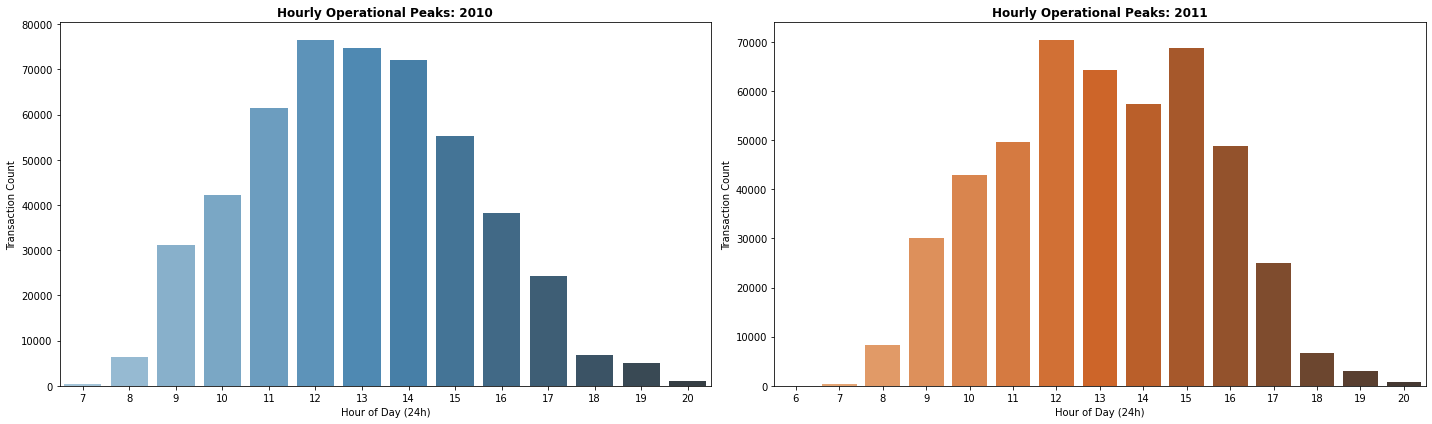

✅ RFM metrics calculated for 4164 unique customers.
✅ RFM metrics calculated for 4175 unique customers.


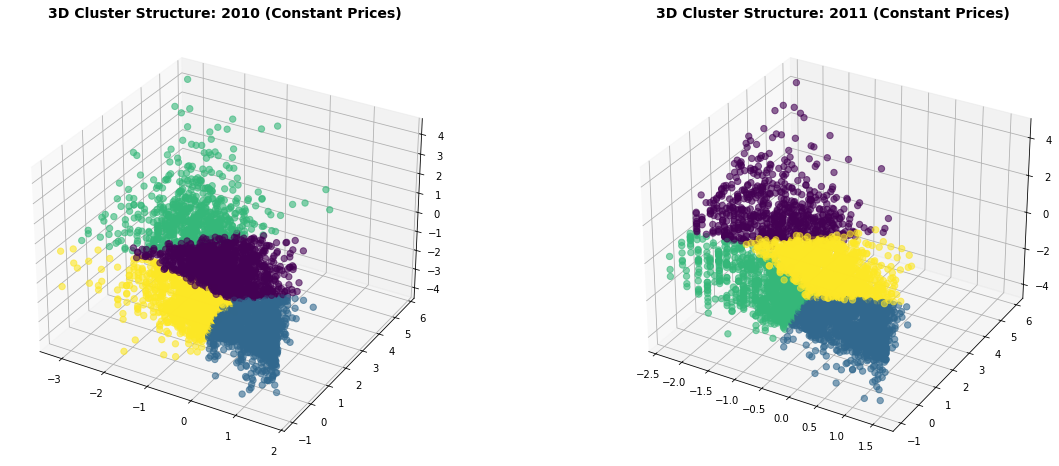

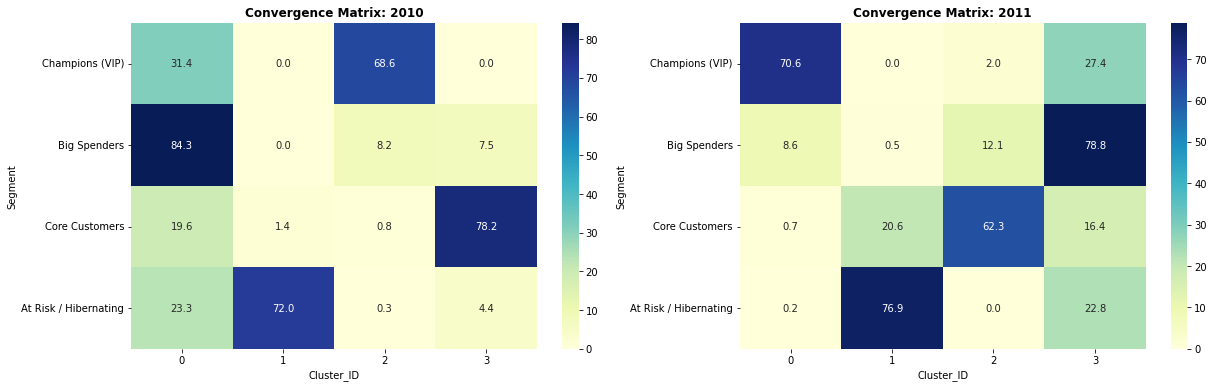

✅ ABC Analysis complete.
✅ ABC Analysis complete.


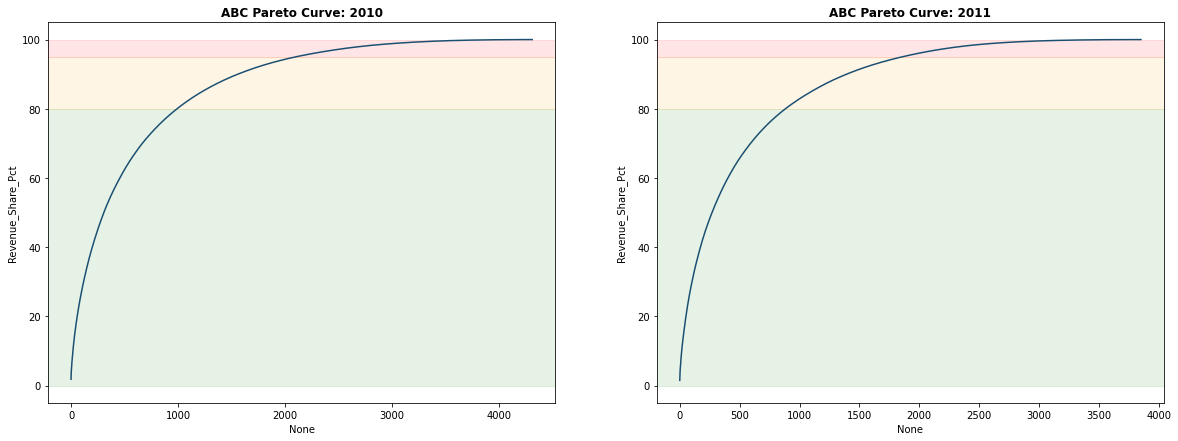

C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_17096\3162689926.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=wealth, x='Revenue_%', y='Segment', palette='magma', ax=axes[i])
C:\Users\Jesus Sanchez\AppData\Local\Temp\ipykernel_17096\3162689926.py:167: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=wealth, x='Revenue_%', y='Segment', palette='magma', ax=axes[i])


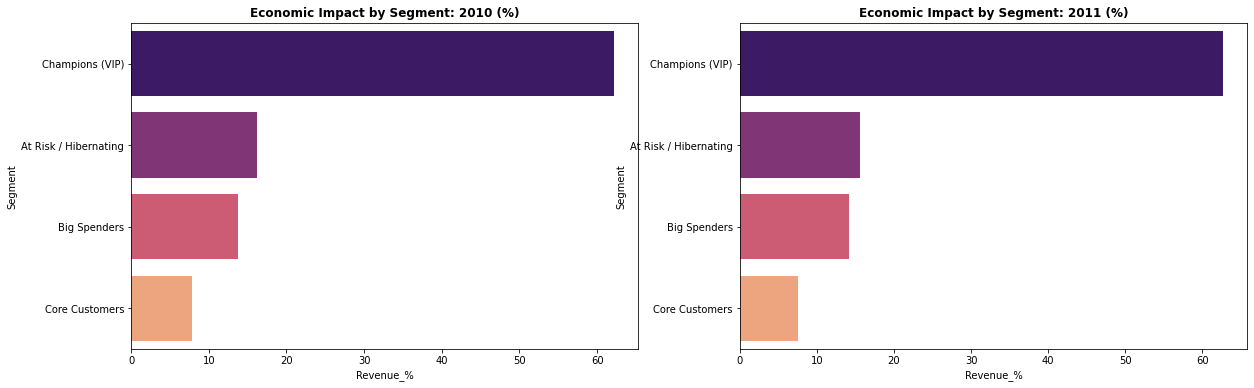

✅ ABC Analysis complete.
✅ ABC Analysis complete.

💰 --- ECONOMIC IMPACT SUMMARY: 2010 ---


,Segment,Monetary,Revenue_%
2,Champions (VIP),"£4,269,543.27",62.2%
0,At Risk / Hibernating,"£1,113,011.09",16.2%
1,Big Spenders,"£945,809.51",13.8%
3,Core Customers,"£537,012.23",7.8%



💰 --- ECONOMIC IMPACT SUMMARY: 2011 ---


,Segment,Monetary,Revenue_%
2,Champions (VIP),"£3,865,851.37",62.7%
0,At Risk / Hibernating,"£962,258.07",15.6%
1,Big Spenders,"£872,869.55",14.2%
3,Core Customers,"£466,259.14",7.6%


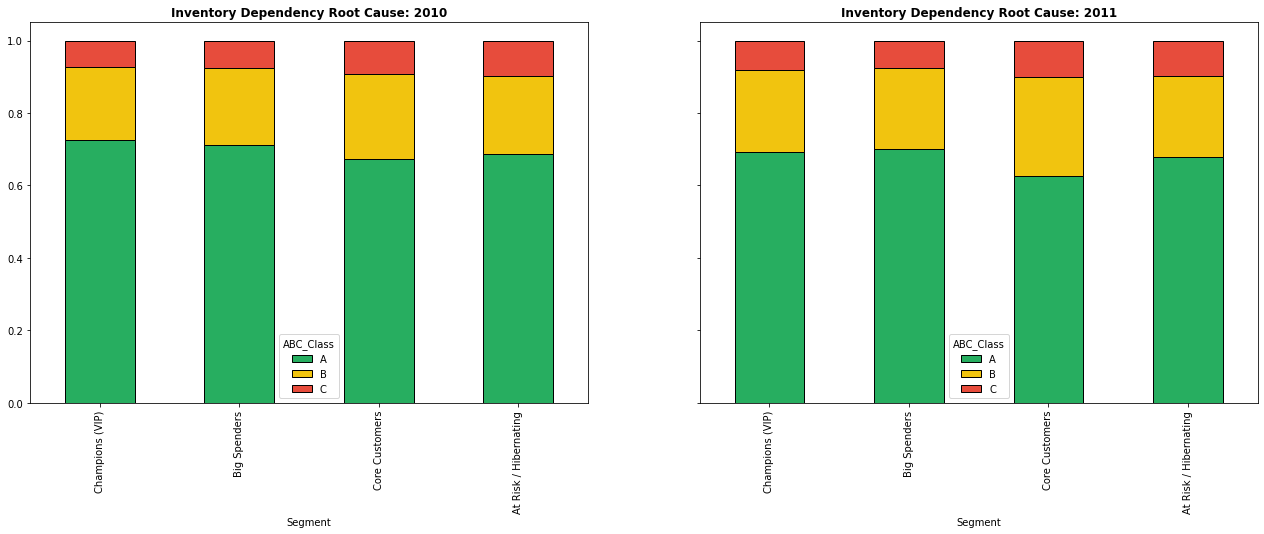

✅ Side-by-Side Analysis Complete. Values adjusted for inflation.


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os
import sys
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# =================================================================
# SECTION 1: SETUP & ECONOMETRIC DEFLATION
# =================================================================

# 1.1 Path Setup
CURRENT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# 1.2 Import Logic from src
from src.feature_engineering import (
    add_time_features, calculate_rfm_metrics, 
    prepare_rfm_for_clustering, perform_abc_analysis
)

# 1.3 Data Loading & Initial Prep
PROCESSED_PATH = r"C:\Users\Jesus Sanchez\Desktop\ALEXIS\1. Pre-Trabajo\1. Supply Chain Intelligence\data\processed\cleaned_retail_data.csv"
df_raw = pd.read_csv(PROCESSED_PATH, parse_dates=['InvoiceDate'])

if 'TotalSum' not in df_raw.columns:
    df_raw['TotalSum'] = df_raw['Quantity'] * df_raw['Price']

df_raw['Year'] = df_raw['InvoiceDate'].dt.year

# 1.4 Inflation Adjustment (Deflating 2011 to 2010 Constant Prices)
INFLATION_2011 = 0.039  # 3.9%
df_2010 = df_raw[df_raw['Year'] == 2010].copy()
df_2011 = df_raw[df_raw['Year'] == 2011].copy()

print(f"📉 Deflating 2011 values (Inflation: {INFLATION_2011*100}%)...")
df_2011['TotalSum'] = df_2011['TotalSum'] / (1 + INFLATION_2011)
df_2011['Price'] = df_2011['Price'] / (1 + INFLATION_2011)

# Apply Time Features
df_2010 = add_time_features(df_2010)
df_2011 = add_time_features(df_2011)

# =================================================================
# SECTION 2: LOGISTICS WORKLOAD (PROPORTIONS & HOURLY PEAKS)
# =================================================================

print("📊 Analyzing Operational Proportions and Peaks...")

# 2.1 Cálculo de Proporciones por Día
DAYS_ORDER = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

def get_day_proportions(df_year, label):
    prop = df_year['DayName'].value_counts(normalize=True).reindex(DAYS_ORDER) * 100
    return prop.rename(f'Share_%_{label}')

logistics_comparison = pd.concat([
    get_day_proportions(df_2010, '2010'),
    get_day_proportions(df_2011, '2011')
], axis=1)

# Añadimos columna de variación absoluta (puntos porcentuales)
logistics_comparison['Abs_Change'] = logistics_comparison['Share_%_2011'] - logistics_comparison['Share_%_2010']

print("\n🗓️ --- LOGISTICS VOLUME PROPORTIONS BY DAY ---")
display(logistics_comparison.style.format("{:.2f}%").background_gradient(cmap='YlGnBu', subset=['Abs_Change']))

# 2.2 Visualización de Picos Horarios (Se mantienen por su valor distributivo)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for i, (year_df, yr, color) in enumerate([(df_2010, 2010, 'Blues_d'), (df_2011, 2011, 'Oranges_d')]):
    sns.countplot(data=year_df, x='Hour', palette=color, ax=axes[i])
    axes[i].set_title(f'Hourly Operational Peaks: {yr}', fontweight='bold')
    axes[i].set_xlabel('Hour of Day (24h)')
    axes[i].set_ylabel('Transaction Count')

plt.tight_layout()
plt.show()

# =================================================================
# SECTION 3: RFM & AI CLUSTERING (K=4)
# =================================================================

def process_year_intelligence(df_year):
    rfm_year = calculate_rfm_metrics(df_year)
    scaled_data, rfm_scaler = prepare_rfm_for_clustering(rfm_year)
    
    kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
    rfm_year['Cluster_ID'] = kmeans.fit_predict(scaled_data)
    
    # Manual Labeling
    rfm_year['R_Score'] = pd.qcut(rfm_year['Recency'], 5, labels=[5, 4, 3, 2, 1]).astype(int)
    rfm_year['F_Score'] = pd.qcut(rfm_year['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5]).astype(int)
    rfm_year['M_Score'] = pd.qcut(rfm_year['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
    
    def assign_segment(row):
        r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
        if r >= 4 and f >= 4 and m >= 4: return 'Champions (VIP)'
        elif m >= 4 and r >= 3: return 'Big Spenders'
        elif r <= 2: return 'At Risk / Hibernating'
        else: return 'Core Customers'
    
    rfm_year['Segment'] = rfm_year.apply(assign_segment, axis=1)
    return rfm_year, scaled_data, rfm_scaler, kmeans

rfm_2010, scaled_2010, _, _ = process_year_intelligence(df_2010)
rfm_2011, scaled_2011, scaler_2011, model_2011 = process_year_intelligence(df_2011)

# 3.1 Side-by-Side 3D Visuals
fig = plt.figure(figsize=(20, 8))
for i, (scaled, rfm_y, yr) in enumerate([(scaled_2010, rfm_2010, 2010), (scaled_2011, rfm_2011, 2011)]):
    ax = fig.add_subplot(1, 2, i+1, projection='3d')
    ax.scatter(scaled['Recency'], scaled['Frequency'], scaled['Monetary'], 
               c=rfm_y['Cluster_ID'], cmap='viridis', s=40, alpha=0.6)
    ax.set_title(f'3D Cluster Structure: {yr} (Constant Prices)', fontsize=14, fontweight='bold')
plt.show()


# 4.2 Comparative Convergence Matrix
order = ['Champions (VIP)', 'Big Spenders', 'Core Customers', 'At Risk / Hibernating']
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for i, (rfm_y, yr) in enumerate([(rfm_2010, 2010), (rfm_2011, 2011)]):
    mtx = pd.crosstab(rfm_y['Segment'], rfm_y['Cluster_ID'], normalize='index') * 100
    sns.heatmap(mtx.reindex(order), annot=True, fmt=".1f", cmap="YlGnBu", ax=axes[i])
    axes[i].set_title(f'Convergence Matrix: {yr}', fontweight='bold')
plt.show()

# =================================================================
# SECTION 5: INVENTORY & ECONOMIC IMPACT (SIDE-BY-SIDE)
# =================================================================

def process_inventory_impact(df_year, rfm_year):
    # ABC Analysis
    abc_res = perform_abc_analysis(df_year)
    sku_map = abc_res.set_index('Description')['ABC_Class'].to_dict()
    df_year['ABC_Class'] = df_year['Description'].map(sku_map)
    
    # Economic Impact by Segment
    segment_wealth = rfm_year.groupby('Segment')['Monetary'].sum().reset_index()
    segment_wealth['Revenue_%'] = (segment_wealth['Monetary'] / segment_wealth['Monetary'].sum()) * 100
    segment_wealth = segment_wealth.sort_values(by='Revenue_%', ascending=False)
    
    return abc_res, segment_wealth, df_year

abc_2010, wealth_2010, df_2010 = process_inventory_impact(df_2010, rfm_2010)
abc_2011, wealth_2011, df_2011 = process_inventory_impact(df_2011, rfm_2011)

# 5.1 Pareto ABC Curves Comparison
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
for i, (abc_y, yr) in enumerate([(abc_2010, 2010), (abc_2011, 2011)]):
    sns.lineplot(data=abc_y, x=abc_y.index, y='Revenue_Share_Pct', ax=axes[i], color='#1B4F72')
    axes[i].axhspan(0, 80, alpha=0.1, color='green', label='Class A')
    axes[i].axhspan(80, 95, alpha=0.1, color='orange', label='Class B')
    axes[i].axhspan(95, 100, alpha=0.1, color='red', label='Class C')
    axes[i].set_title(f'ABC Pareto Curve: {yr}', fontweight='bold')
plt.show()

# 5.2 Economic Impact Comparison (New Visualization)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
for i, (wealth, yr) in enumerate([(wealth_2010, 2010), (wealth_2011, 2011)]):
    sns.barplot(data=wealth, x='Revenue_%', y='Segment', palette='magma', ax=axes[i])
    axes[i].set_title(f'Economic Impact by Segment: {yr} (%)', fontweight='bold')
plt.show()

# =================================================================
# SECTION 4: INVENTORY & ECONOMIC IMPACT TABLES
# =================================================================

def get_economic_impact(df_year, rfm_year):
    # Mapping ABC Classes
    abc_res = perform_abc_analysis(df_year)
    sku_map = abc_res.set_index('Description')['ABC_Class'].to_dict()
    df_year['ABC_Class'] = df_year['Description'].map(sku_map)
    
    # Wealth Concentration by Segment
    wealth = rfm_year.groupby('Segment')['Monetary'].sum().reset_index()
    wealth['Revenue_%'] = (wealth['Monetary'] / wealth['Monetary'].sum()) * 100
    wealth = wealth.sort_values(by='Revenue_%', ascending=False)
    
    return wealth, df_year

wealth_2010, df_2010 = get_economic_impact(df_2010, rfm_2010)
wealth_2011, df_2011 = get_economic_impact(df_2011, rfm_2011)

# DISPLAYING THE IMPACT TABLES (The "Tablitas" you requested)
print("\n💰 --- ECONOMIC IMPACT SUMMARY: 2010 ---")
display(wealth_2010.style.format({'Monetary': '£{:,.2f}', 'Revenue_%': '{:.1f}%'}))

print("\n💰 --- ECONOMIC IMPACT SUMMARY: 2011 ---")
display(wealth_2011.style.format({'Monetary': '£{:,.2f}', 'Revenue_%': '{:.1f}%'}))


# =================================================================
# SECTION 5: ROOT CAUSE & PERSISTENCE
# =================================================================

df_en_2010 = df_2010.merge(rfm_2010[['Segment']], left_on='Customer ID', right_index=True, how='left')
df_en_2011 = df_2011.merge(rfm_2011[['Segment']], left_on='Customer ID', right_index=True, how='left')

fig, axes = plt.subplots(1, 2, figsize=(22, 7), sharey=True)
order = ['Champions (VIP)', 'Big Spenders', 'Core Customers', 'At Risk / Hibernating']

for i, (df_en, yr) in enumerate([(df_en_2010, 2010), (df_en_2011, 2011)]):
    pd.crosstab(df_en['Segment'], df_en['ABC_Class'], normalize='index').reindex(order).plot(
        kind='bar', stacked=True, color=['#27AE60', '#F1C40F', '#E74C3C'], ax=axes[i], edgecolor='black'
    )
    axes[i].set_title(f'Inventory Dependency Root Cause: {yr}', fontweight='bold')
plt.show()

# Persistence
models_path = '../models'
if not os.path.exists(models_path): os.makedirs(models_path)
joblib.dump(model_2011, os.path.join(models_path, 'rfm_kmeans_2011.pkl'))
joblib.dump(scaler_2011, os.path.join(models_path, 'rfm_scaler_2011.pkl'))

print(f"✅ Side-by-Side Analysis Complete. Values adjusted for inflation.")